## Procedure

1. Clean and transform data
2. Exploratory Data Analysis (EDA)
3. Handle imbalanced classes
4. **Modeling & evaluation**
5. Conclusion
6. Clean code with classes & functions

Note: We shouldn't be using classification accuracy/error rate for evaluating classifiers, due to huge class imbalance in our dataset. Accuracy applies a 0.50 threahold to decide between classes, which is not our case.

**We want probabilities of class memberships instead of just labels.**

Instead, precision-recall curves predict probabilities of an observation belonging to each class in a classification problem rather than predicting the classes directly. We will be using precision-recall (instead of ROC curves) because we are dealing with class imbalance and precision-recall calculations do not make use of the true negatives. It is only concerned with the correct prediction of the minority class, because we are generally less interested in the ability of the model predicting class 0 correctly (which we have a lot of).

<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{True&space;Positives}{(True&space;Positives&space;&plus;&space;False&space;Positives)&space;}" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{True&space;Positives}{(True&space;Positives&space;&plus;&space;False&space;Positives)&space;}" title="\frac{True Positives}{(True Positives + False Positives) }" /></a>

The calculations do not make use of the true negatives. It is only concerned with the correct prediction of the miniority class (`failure=1`)

In [9]:
import numpy as np
from datetime import datetime
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.metrics import f1_score, classification_report, recall_score

from sklearn.linear_model import LogisticRegression

In [2]:
X_train_resampled = joblib.load('../work/data/X_train_resampled')
y_train_resampled = joblib.load('../work/data/y_train_resampled')
X_test = joblib.load('../work/data/X_test')
y_test = joblib.load('../work/data/y_test')

## Logistic Regression
Draws a line (hyperplane) between different classes of points. The further a point is from the boundary line, the more its score (estimate) increases (nearing 0 or 1). 

In [16]:
LogisticRegression.get_params(LogisticRegression).keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [8]:
# Fit model

start = datetime.now()

params = {
    'penalty': ['l1','l2'],
    'C': np.arange(1,14,3)
}

lr = GridSearchCV(LogisticRegression(), param_grid=params, cv=ShuffleSplit(random_state=88), n_jobs=-1)
lr.fit(X_train_resampled, y_train_resampled)

print("Time: ", datetime.now() - start)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Time:  0:00:54.690739


In [13]:
print("Accuracy: ", lr.score(X_test,y_test))
print("Recall: ", recall_score(y_test, lr.predict(X_test)))

Accuracy:  0.904200915687
Recall:  0.791666666667


In [28]:
probability = lr.predict(X_test)

In [29]:
print(classification_report(y_test, probability,
                            target_names=["failure=0", "failure=1"]))

             precision    recall  f1-score   support

  failure=0       1.00      1.00      1.00     37325
  failure=1       0.50      0.04      0.08        24

avg / total       1.00      1.00      1.00     37349



In [6]:
# predict probabilities
probs = lr.predict_proba(X_test)

# keep probabilities for the positive outcome only
probs = probs[:, 1]

# predict class values
yhat = lr.predict(X_test)

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# calculate F1 score
f1 = f1_score(y_test, yhat)

# calculate precision-recall AUC
auc = auc(recall, precision)

# calculate average precision score
ap = average_precision_score(y_test, probs)

print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))

NameError: name 'precision_recall_curve' is not defined

In [41]:
# predict probabilities
probs = lr.predict_proba(X_test)

# keep probabilities for the positive outcome only
probs = probs[:, 1]

# predict class values
yhat = lr.predict(X_test)

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# calculate F1 score
f1 = f1_score(y_test, yhat)

# calculate precision-recall AUC
auc = auc(recall, precision)

# calculate average precision score
ap = average_precision_score(y_test, probs)

print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))

f1=0.077 auc=0.047 ap=0.047


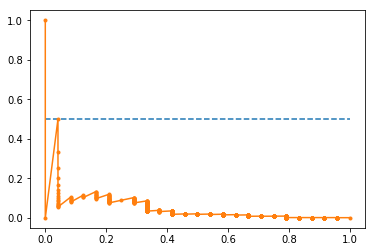

In [43]:
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')

# plot the roc curve for the model
plt.plot(recall, precision, marker='.')
plt.show()

## Decision Tree
Recursively subdivides the instance space into finer and finer subregions until it is all one class (or good enough). New instances start at the root node and takes the appropriate path until it reaches a lead node, which determines the classification by checking the classes of the training instances that reached that leaf, and the majority determines the class. For that leaf, the score is calculated by:

<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{majority&space;instances}{(majority&space;instances&space;&plus;&space;minority&space;instances)&space;}" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{majority&space;instances}{(majority&space;instances&space;&plus;&space;minority&space;instances)&space;}" title="\frac{majority instances}{(majority instances + minority instances) }" /></a>

When using scikit-learn's DecisionTreeClassifier, always set min_samples_leaf to something like 5 or 10. Its default value of 1 is useless and is guaranteed to overfit. 

In [50]:
DecisionTreeClassifier.get_params(DecisionTreeClassifier).keys()

dict_keys(['class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [60]:
# Fit model

start = datetime.now()

params = {
    'max_depth': np.arange(1,14,3),
    'min_samples_leaf': np.arange(1,14,3)
}

dt = GridSearchCV(DecisionTreeClassifier(), param_grid=params, cv=ShuffleSplit(random_state=88), n_jobs=-1)
dt.fit(X_train, y_train)

print("Time: ", datetime.now() - start)

Time:  0:00:44.701961


In [61]:
# predict probabilities
probs = dt.predict_proba(X_test)

# keep probabilities for the positive outcome only
probs = probs[:, 1]

# predict class values
yhat = dt.predict(X_test)

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# calculate F1 score
f1 = f1_score(y_test, yhat)

# calculate precision-recall AUC
auc = auc(recall, precision)

# calculate average precision score
ap = average_precision_score(y_test, probs)

print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


TypeError: 'numpy.float64' object is not callable

In [54]:
# predict probabilities
probs = dt.predict_proba(X_test)

# keep probabilities for the positive outcome only
probs = probs[:, 1]

# predict class values
yhat = dt.predict(X_test)

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# calculate F1 score
f1 = f1_score(y_test, yhat)

# calculate precision-recall AUC
auc = auc(recall, precision)

# calculate average precision score
ap = average_precision_score(y_test, probs)

print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))

f1=0.000 auc=0.168 ap=0.168


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


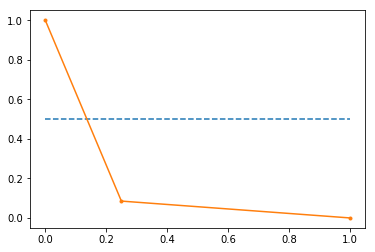

In [55]:
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')

# plot the roc curve for the model
plt.plot(recall, precision, marker='.')
plt.show()

In [7]:
optimal_max_depth = dt.best_estimator_.max_depth
optimal_max_depth

1

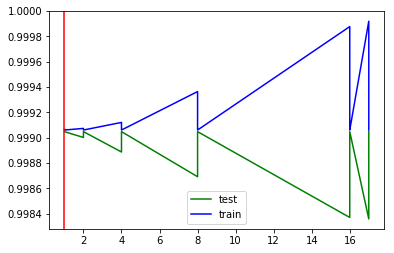

In [11]:
cv_results = pd.DataFrame(dt.cv_results_)

plt.plot(cv_results['param_max_depth'], cv_results['mean_test_score'], c='g', label='test')
plt.plot(cv_results['param_max_depth'], cv_results['mean_train_score'], c='b', label='train')
plt.axvline(optimal_max_depth, c='r')
plt.legend()

`cv_results_df['mean_train_score']` are the means of what you get when applied to CROSS-VALIDATED (hold-out) test data. This is why it's different from the `.score` results above. The `.score` results are the means of what you actually get when applied to REAL TEST data.

## Random Forest

In [14]:
start = datetime.now()


params = {
    'rf__n_estimators':[10,100],
    'rf__max_depth':[10,40,None]
}

rf = GridSearchCV(RandomForestClassifier(random), param_grid=params, cv=ShuffleSplit(random_state=88))
rf.fit(X_train, y_train)

ValueError: Invalid parameter rf for estimator RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False). Check the list of available parameters with `estimator.get_params().keys()`.

In [13]:
print('RF train score: {}'.format(rf.score(X_train, y_train)))
print('RF test score: {}'.format(rf.score(X_test, y_test)))

NameError: name 'rf' is not defined

### K-Nearest Neighbor
If for example, `k=5`, for every new instance, 5 of its nearest neighbors are randomly selected and some function like majority is applied to the five neighbors. To assign a score, divide the number of positive instances by the total and return the fraction. 

In [ ]:
start = datetime.now()

params = {
    'n_neighbors': list(range(2,30,2))
}

knn = GridSearchCV(KNeighborsClassifier(), param_grid=params, cv=ShuffleSplit(random_state=88))
knn.fit(X_train, y_train)
display(pd.DataFrame(knn.cv_results_))
print(gs_knn.cv_results_['mean_test_score'])

print("Time: ", datetime.now() - start)

In [ ]:
print('KNN train score: {}'.format(knn.score(X_train, y_train)))
print('KNN test score: {}'.format(knn.score(X_test, y_test)))

## Naive Bayes 
This models class probabilities - the posteriors - directly to make a classification. 